# 11 Reprojecting
In this section we will learn how to join dataframes and will apply this to creating a choropleth map with `geopandas`.

## About the data
The first dataset we will use is a list of Arctic communities and their location [1] created by the Alaska Native Tribal Health Consortium. This data comes in a GeoJSON file with the following attributes:

name: name of Arctic community,
population: population of Arctic community, as of 2022
country: country that the Arctic community falls within (see dataset metadata for the codes)
geoname-id: numeric codes that uniquely identify all administrative/legal and statistical geographic areas for which the Census Bureau tabulates data
The second dataset is Natural Earth’s medium-scale cultural boundaries data for countries (1:50m). We can obtain this dataset by downloading the shapefile. Natural Earth is a public domain dataset with free, ready-to-use data for creating maps.

The third dataset we will use is a CSV file with the country codes and names of the Arctic countries in the Arctic communities dataset. This dataset was created for educational purposes for this lesson based on the metadata of the Arctic communities dataset and the country names in Natural Earth’s dataset. It can be accessed here.

## Import data
We will first import the countries shapefile and adapt it for wrangling purposes:


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
# Import countries shapefile
fp = os.path.join('data','ne_50m_admin_0_countries','ne_50m_admin_0_countries.shp')
countries = gpd.read_file(fp)
countries.columns = countries.columns.str.lower()  # Simplify column names
countries = countries[['admin', 'type', 'geometry']]
countries.head(3)

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds220-env/share/proj failed


,admin,type,geometry
0,Zimbabwe,Sovereign country,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,Sovereign country,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,Sovereign country,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."


In [3]:
# Import Arctic communities GeoJSON directly from URL
URL = 'https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Aed7718ae-fb0d-43dd-9270-fbfe80bfc7a4'
communities = gpd.read_file(URL)
communities.head()

,name,population,country,geoname-id,geometry
0,Udomlya,32373,RU,452949,POINT (34.99250 57.87944)
1,Valmiera,26963,LV,453754,POINT (25.42751 57.54108)
2,Ventspils,42644,LV,454310,POINT (21.57288 57.38988)
3,Vec-Liepāja,85260,LV,454432,POINT (21.01667 56.53333)
4,Tukums,18348,LV,454768,POINT (23.15528 56.96694)


The CRS of the `communities` is EPSG:4326. Remember all GeoJSON files are given in this CRS and all points are expressed in longitude and latitude units of decimal degrees.

In [4]:
print(countries.crs)
countries.crs == communities.crs

EPSG:4326


True

Since the CRSs of our geospatila data match, it is easy to take a quick look at our communities data by plotting it on top of the countries dataframe:

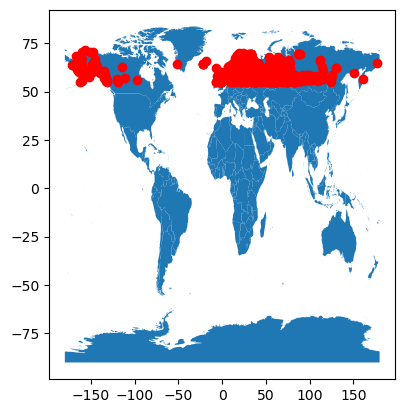

In [5]:
# Verify CRSs match
assert countries.crs == communities.crs

fig, ax = plt.subplots()
countries.plot(ax=ax)
communities.plot(ax=ax, color='red')
plt.show()

Finally, we import the country names and codes CSV:

In [6]:
# Import country names from URL
URL = 'https://raw.githubusercontent.com/MEDS-eds-220/MEDS-eds-220-course/refs/heads/main/book/chapters/lesson-12-merge-data/country_names.csv'
country_names = pd.read_csv(URL)
country_names

,country,admin
0,RU,Russia
1,LV,Latvia
2,EE,Estonia
3,LT,Lithuania
4,SE,Sweden
5,BY,Belarus
6,FI,Finland
7,NO,Norway
8,DK,Denmark
9,FO,Faroe Islands


## Arctic communities by country
Next, we want to calculate the number of Arctic communities by country.

In [7]:
# Create data frame with number of communities per country
n_comms = (communities.groupby('country')
                      .size()
                      .reset_index(name='n_communities'))

Let’s break this down:

- We start with our `communities` dataframe and use `groupby('country')` to group by country code.
- Then we use `size()` as an aggregator function to calculate the size of each group.
- The result of this operation is a `pandas.Series` indexed by the `country` values.
- By resetting the index we transform the `pandas.Series `into a `pandas.DataFrame`, the index is now a column named `country` and the values of the series are named `n_communities`.

In [8]:
# Number of Arctic communities per country
n_comms

,country,n_communities
0,AX,1
1,BY,8
2,CA,7
3,DK,72
4,EE,14
5,FI,98
6,FO,1
7,GB,96
8,GL,1
9,IS,5


## `if-else` statements
Our goal is to merge the `n_comms` and the `countries` data frames. To merge two data frames they need to have at least one column in common. Currently our datasets do not have any columns in common:

In [9]:
set(countries.columns).intersection(n_comms.columns)

set()

The output `set()` represents the empty set. This might not be as informative, so let’s write a different information statement:

In [10]:
common_columns = set(countries.columns).intersection(n_comms.columns)

# Check if there are any common columns
if len(common_columns) != 0:
    print(f"Common columns: {common_columns}")
else:
    print("No common columns")

No common columns


Remember that an `if-else` statement is a control structure that allows code to make decisions: it checks a condition, and if that condition is true, it executes one block of code (the `if` block); if the condition is false, it executes a different block (the `else` block). This enables programs to respond differently depending on specific criteria or inputs.

**Check-in:** Wrap up the previous code into a function called `check_common_columns` that prints a message depending of whether two data frames have common columns or not. Don’t forget to include a docstring!

In [11]:
def check_common_columns(df1, df2):
    """
    Check whether two data frames have matching columns and 
    print common columns or message indicating no common columns
    
    Parameters:
        df1 (pd.DataFrame): first data frame
        df2 (pd.DataFrame): second data frame
        
    Returns: 
        None
    """    
    common_columns = set(df1.columns).intersection(df2.columns)

    # Check if there are any common columns
    if len(common_columns) != 0:
        print(f"Common columns: {common_columns}")
    else:
        print("No common columns")
    

## Merging data frames
We can use the `country_names` data frame to add the names countries into the `n_comms` data which, in turn, will allow us to merge that data frame with the `country_names` data. To merge dataframes we can use the `pandas.merge()` function. The basic syntax for it is:

```
output_df = pd.merge(left_df,
                     right_df, 
                     how = type_of_join, 
                     on = column_to_join)
```
where

- `output_df` is the dataframe resulting from the merge,
`left_df` is the dataframe we have “on the left side”,
`right_df` is the dataframe we have “on the right side”,
- how specifies the type of join between the left and right dataframes, (check the options here), the default is to do an inner join,
- `on` specifies the column to join on, this column must be present in both our dataframes.

When merging a `geopandas.GeoDataFrame` with a `pandas.DataFrame`, the `geopandas.GeoDataFrame` must be “on the left” to retain the geospatial information. Otherwise, the output will be a `pandas.DataFrame`.

So, we merge the `n_comms` and `country_names` data frames using a left join:

![]("join-diagram-left.png")

In [12]:
n_comms = pd.merge(n_comms,
                   country_names,
                   how='left',
                   on='country')
n_comms

,country,n_communities,admin
0,AX,1,Aland Islands
1,BY,8,Belarus
2,CA,7,Canada
3,DK,72,Denmark
4,EE,14,Estonia
5,FI,98,Finland
6,FO,1,Faroe Islands
7,GB,96,United Kingdom
8,GL,1,Greenland
9,IS,5,Iceland


We can reuse our function to check that `n_comms` and `countries` now have a common column on which we can merge them:

In [13]:
check_common_columns(n_comms, countries)

Common columns: {'admin'}


**Check-in:** Create a new variable named `arctic_countries` which is the result of an inner join between our `countries` and `n_comms` dataframes. The inner joun will merge the subset of rows that have matches in both the left table and the right table.

![]("join-diagram-inner.png")

In [14]:
arctic_countries = pd.merge(countries,
                            n_comms,
                            how = "inner",
                            on = "admin"
                           )
arctic_countries

,admin,type,geometry,country,n_communities
0,United States of America,Country,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576...",US,115
1,United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...",GB,96
2,Sweden,Sovereign country,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57...",SE,133
3,Russia,Sovereign country,"MULTIPOLYGON (((145.88154 43.45952, 145.89561 ...",RU,774
4,Norway,Sovereign country,"MULTIPOLYGON (((20.62217 69.03687, 20.49199 69...",NO,48
5,Lithuania,Sovereign country,"MULTIPOLYGON (((20.95781 55.27891, 20.89980 55...",LT,26
6,Latvia,Sovereign country,"POLYGON ((26.59355 55.66753, 26.54287 55.67241...",LV,25
7,Iceland,Sovereign country,"POLYGON ((-15.54312 66.22852, -15.42847 66.224...",IS,5
8,Finland,Country,"MULTIPOLYGON (((24.15547 65.80527, 24.04902 65...",FI,98
9,Estonia,Sovereign country,"MULTIPOLYGON (((27.35195 57.52812, 27.32656 57...",EE,14


Notice that we lost the Aland Islands. Lets double check

In [20]:
# Update index
arctic_countries = arctic_countries.set_index('admin')
arctic_countries.head()

,type,geometry,country,n_communities
admin,,,,
United States of America,Country,"MULTIPOLYGON (((-3725925.296 -146595.535, -372...",US,115
United Kingdom,Country,"MULTIPOLYGON (((2904994.768 -3188931.508, 2904...",GB,96
Sweden,Sovereign country,"MULTIPOLYGON (((3215304.166 -1562900.287, 3215...",SE,133
Russia,Sovereign country,"MULTIPOLYGON (((-1005666.554 5231427.614, -100...",RU,774
Norway,Sovereign country,"MULTIPOLYGON (((2090870.997 -947485.892, 20890...",NO,48


The `values` attribute of a data frame returns *all* the values in the data frame as an array. We can verify the value ‘Aland Islands’ was *nowhere* in our original countries dataframe like this:

In [21]:
# Check Aland Islands is nowhere in data frame
'Aland Islands' not in countries.values

True

The Aland Islands is an autonomous region of Finland and there is one Arctic community registered in this region. We will directly add one to Finland to not lose this piece of data:

In [22]:
arctic_countries.at['Finland', 'n_communities'] += 1

## Choropleth map
A [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) is an efficient way to visualize aggregate data per region.

Making a choropleth map from our polygons `GeoDataFrame` is easy; we just need to specify the `column` parameter in `plot()` and make it equal to the column with the values we want to plot in each country:

<Axes: >

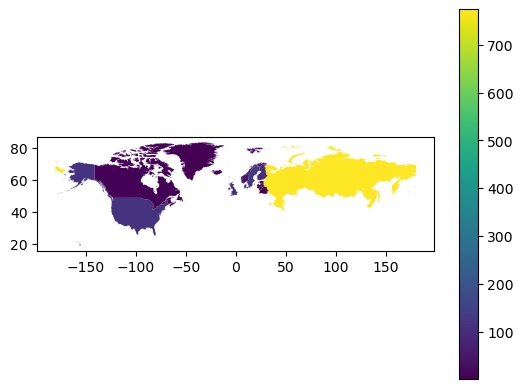

In [17]:
arctic_countries.plot(column='n_communities',
                      legend=True)

## Reprojecting

Remember that CRSs reflect cultural views and even biases. Any map projection involves choices about which areas to emphasize, minimize, or distort, and those choices can influence how viewers perceive different regions. In our map, using the EPSG:4326 CRS is, among other things, mapping the Arctic regions as far apart, while they are actually near each other.

**Reprojecting** means changing the coordinate reference system of your geospatial data. In our case, we will reproject the Alaska geo-dataframe to the CRS EPSG:3413. This CRS is a *projected* CRS, better suited for working with data from the Arctic region.

Changing CRSs in GeoPandas is very simple using the `to_crs()` method for `geopandas.GeoDataFrames`. The general syntax is:

`updated_geodf = geodf.to_crs(new_crs)`

where:

- `updated_geodf` is the output of the method, a new geodataframe (`to_crs()` does not work in place),
- `geodf` is the `geopandas.GeoDataFrame` we want to transform,
- `new_crs` the CRS we want to convert to, this is an object of type CRS or string representing the CRS (ex: '`epsg:3413`').

In our case:

In [19]:
# Reproject to CRS optimized for Arctic region
arctic_countries = arctic_countries.to_crs('epsg:3413')

We can now use the reprojected data to update our map:

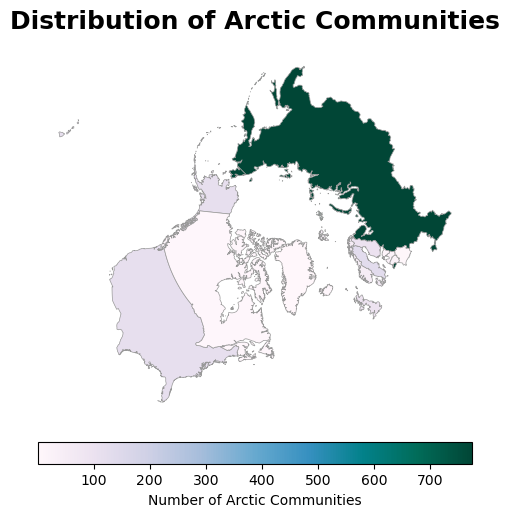

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

# Remove the axis for a cleaner map
ax.axis('off')

# Create choropleth map of communities
# Plot with refined color and edge style
arctic_countries.plot(
    ax=ax,
    column='n_communities',
    cmap='PuBuGn',
    legend=True,
    edgecolor="0.6",
    linewidth=0.5,
    legend_kwds={
        "shrink": 0.7,
        "label": "Number of Arctic Communities",
        "orientation": "horizontal",
        "pad": 0.05
    }
)

# Add title and subtitle for better context
ax.set_title('Distribution of Arctic Communities', fontsize=18, weight='bold', pad=15)

plt.show()

Although the new projection clearly improves the presentation of the data, there are still issues with this plot! Mainly, the entire United States territory is in it, when we should only have Alaska. **In our next lesson we will review startegies to clip and subset vector data and return to this plot in our discussion section.**